In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 801ms/step - loss: 0.5870
Average validation loss: 0.7014213800430298
4/4 [==============================] - 8s 816ms/step - loss: 0.5870 - val_loss: 0.7014
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 770ms/step - loss: 0.4436 - val_loss: 0.7014
Average validation loss: 0.34346047043800354
4/4 [==============================] - 12s 785ms/step - loss: 0.4436 - val_loss: 0.5224
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 812ms/step - loss: 0.3566 - val_loss: 0.5224
Average validation loss: 0.27480626106262207
4/4 [==============================] - 15s 825ms/step - loss: 0.3566 - val_loss: 0.4399
Saved model weights to 'c:\Users\user\Des

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 713ms/step - loss: 0.0331
Average validation loss: 7.156585740686339e-11
8/8 [==============================] - 6s 726ms/step - loss: 0.0331 - val_loss: 7.1566e-11
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 711ms/step - loss: 0.0315 - val_loss: 7.1566e-11
Average validation loss: 4.74074078570788e-11
8/8 [==============================] - 12s 724ms/step - loss: 0.0315 - val_loss: 5.9487e-11
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 728ms/step - loss: 0.0305 - val_loss: 5.9487e-11
Average validation loss: 0.00033485346648376435
8/8 [==============================] - 18s 738ms/step - loss: 0.0305 - val_loss: 1.1162e-04
Epoch 4/10
8

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 729ms/step - loss: 0.0398
Average validation loss: 0.11092305183410645
12/12 [==============================] - 9s 742ms/step - loss: 0.0398 - val_loss: 0.1109
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 729ms/step - loss: 0.0405 - val_loss: 0.1109
Average validation loss: 0.19172983368237814
12/12 [==============================] - 18s 742ms/step - loss: 0.0405 - val_loss: 0.1513
Epoch 3/10
12/12 [==============================] - 27s 736ms/step - loss: 0.0403 - val_loss: 0.1513
Average validation loss: 0.14996099472045898
12/12 [==============================] - 27s 749ms/step - loss: 0.0403 - val_loss: 0.1509
Epoch 4/10
12/12 [==============================] - 36s 717ms/step - loss: 0.0401 - val_loss: 0.1509
Average validation loss: 0.034024012464821375
12/12 [=====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 719ms/step - loss: 0.0448
Average validation loss: 0.21198092402104862
16/16 [==============================] - 12s 733ms/step - loss: 0.0448 - val_loss: 0.2120
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 727ms/step - loss: 0.0434 - val_loss: 0.2120
Average validation loss: 0.038278534717392176
16/16 [==============================] - 24s 741ms/step - loss: 0.0434 - val_loss: 0.1251
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 719ms/step - loss: 0.0422 - val_loss: 0.1251
Average validation loss: 0.051000981155084446
16/16 [==============================] - 36s 733ms/step - loss: 0.0422 - val_loss: 0.1004
Epoch 4/10
16/16 [====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 727ms/step - loss: 0.0279
Average validation loss: 0.30287867834595056
20/20 [==============================] - 15s 740ms/step - loss: 0.0279 - val_loss: 0.3029
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 716ms/step - loss: 0.0293 - val_loss: 0.3029
Average validation loss: 0.0940918705862714
20/20 [==============================] - 29s 728ms/step - loss: 0.0293 - val_loss: 0.1985
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 716ms/step - loss: 0.0296 - val_loss: 0.1985
Average validation loss: 0.38640965247791714
20/20 [==============================] - 44s 728ms/step - loss: 0.0296 - val_loss: 0.2611
Epoch 4/10
20/20 [=======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 721ms/step - loss: 0.0232
Average validation loss: 0.07239582762122154
24/24 [==============================] - 18s 732ms/step - loss: 0.0232 - val_loss: 0.0724
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 719ms/step - loss: 0.0233 - val_loss: 0.0724
Average validation loss: 0.03392850483457247
24/24 [==============================] - 35s 730ms/step - loss: 0.0233 - val_loss: 0.0532
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 714ms/step - loss: 0.0241 - val_loss: 0.0532
Average validation loss: 0.0933082327246666
24/24 [==============================] - 53s 725ms/step - loss: 0.0241 - val_loss: 0.0665
Epoch 4/10
24/24 [=======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 726ms/step - loss: 0.0297
Average validation loss: 0.16141900569200515
40/40 [==============================] - 29s 737ms/step - loss: 0.0297 - val_loss: 0.1614
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 719ms/step - loss: 0.0269 - val_loss: 0.1614
Average validation loss: 0.05542501732707024
40/40 [==============================] - 59s 731ms/step - loss: 0.0269 - val_loss: 0.1084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 720ms/step - loss: 0.0260 - val_loss: 0.1084
Average validation loss: 0.029477204382419585
40/40 [==============================] - 88s 733ms/step - loss: 0.0260 - val_loss: 0.0821
Saved model weights to 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 721ms/step - loss: 0.0219
Average validation loss: 0.019373298933108647
48/48 [==============================] - 35s 733ms/step - loss: 0.0219 - val_loss: 0.0194
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 724ms/step - loss: 0.0188 - val_loss: 0.0194
Average validation loss: 0.018796266987919807
48/48 [==============================] - 71s 736ms/step - loss: 0.0188 - val_loss: 0.0191
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 722ms/step - loss: 0.0172 - val_loss: 0.0191
Average validation loss: 0.012540843473592153
48/48 [==============================] - 106s 735ms/step - loss: 0.0172 - val_loss: 0.0169
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 729ms/step - loss: 0.0208
Average validation loss: 0.023279624991118908
56/56 [==============================] - 42s 741ms/step - loss: 0.0208 - val_loss: 0.0233
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 727ms/step - loss: 0.0179 - val_loss: 0.0233
Average validation loss: 0.01661129362348999
56/56 [==============================] - 83s 740ms/step - loss: 0.0179 - val_loss: 0.0199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 124s 730ms/step - loss: 0.0158 - val_loss: 0.0199
Average validation loss: 0.024384376925549338
56/56 [==============================] - 125s 742ms/step - loss: 0.0158 - val_loss: 0.0214
Epoch 4/10
56/56 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 734ms/step - loss: 0.0156
Average validation loss: 0.016950515913777053
64/64 [==============================] - 48s 746ms/step - loss: 0.0156 - val_loss: 0.0170
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 732ms/step - loss: 0.0126 - val_loss: 0.0170
Average validation loss: 0.011028444598196074
64/64 [==============================] - 96s 744ms/step - loss: 0.0126 - val_loss: 0.0140
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 142s 730ms/step - loss: 0.0116 - val_loss: 0.0140
Average validation loss: 0.019903064880054444
64/64 [==============================] - 143s 742ms/step - loss: 0.0116 - val_loss: 0.0160
Epoch 4/10
64/64 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 719ms/step - loss: 0.0138
Average validation loss: 0.012536679860204458
72/72 [==============================] - 53s 733ms/step - loss: 0.0138 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 727ms/step - loss: 0.0115 - val_loss: 0.0125
Average validation loss: 0.007942074237184392
72/72 [==============================] - 106s 739ms/step - loss: 0.0115 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 159s 730ms/step - loss: 0.0099 - val_loss: 0.0102
Average validation loss: 0.01157956407405436
72/72 [==============================] - 160s 742ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 4/10
72/72 [

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 720ms/step - loss: 0.0128
Average validation loss: 0.013166344002820551
80/80 [==============================] - 59s 733ms/step - loss: 0.0128 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 723ms/step - loss: 0.0111 - val_loss: 0.0132
Average validation loss: 0.007682608044706285
80/80 [==============================] - 117s 735ms/step - loss: 0.0111 - val_loss: 0.0104
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 719ms/step - loss: 0.0095 - val_loss: 0.0104
Average validation loss: 0.009085587866138667
80/80 [==============================] - 176s 731ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 4/10
80/8

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 721ms/step - loss: 0.0158
Average validation loss: 0.06769213445174198
96/96 [==============================] - 70s 733ms/step - loss: 0.0158 - val_loss: 0.0677
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 722ms/step - loss: 0.0137 - val_loss: 0.0677
Average validation loss: 0.04748580639716238
96/96 [==============================] - 141s 734ms/step - loss: 0.0137 - val_loss: 0.0576
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 722ms/step - loss: 0.0133 - val_loss: 0.0576
Average validation loss: 0.035614689102703746
96/96 [==============================] - 212s 735ms/step - loss: 0.0133 - val_loss: 0.0503
Saved model weigh

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 722ms/step - loss: 0.0136
Average validation loss: 0.009442032974523803
120/120 [==============================] - 88s 735ms/step - loss: 0.0136 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 721ms/step - loss: 0.0117 - val_loss: 0.0094
Average validation loss: 0.023634037904105298
120/120 [==============================] - 176s 733ms/step - loss: 0.0117 - val_loss: 0.0165
Epoch 3/10
120/120 [==============================] - 263s 723ms/step - loss: 0.0103 - val_loss: 0.0165
Average validation loss: 0.008897601935805
120/120 [==============================] - 264s 735ms/step - loss: 0.0103 - val_loss: 0.0140
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_150.pth'.
Epoch 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 0.0109
Average validation loss: 0.015081213891654165
144/144 [==============================] - 106s 733ms/step - loss: 0.0109 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 722ms/step - loss: 0.0094 - val_loss: 0.0151
Average validation loss: 0.009288686385843903
144/144 [==============================] - 211s 734ms/step - loss: 0.0094 - val_loss: 0.0122
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 316s 724ms/step - loss: 0.0083 - val_loss: 0.0122
Average validation loss: 0.011124981814289607
144/144 [==============================] - 317s 736ms/step - loss: 0.0083 - val_loss: 0.0118
E

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 726ms/step - loss: 0.0092
Average validation loss: 0.0065459364514026674
160/160 [==============================] - 118s 739ms/step - loss: 0.0092 - val_loss: 0.0065
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 234s 725ms/step - loss: 0.0076 - val_loss: 0.0065
Average validation loss: 0.0115387848297388
160/160 [==============================] - 236s 737ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 3/10
160/160 [==============================] - 352s 723ms/step - loss: 0.0070 - val_loss: 0.0090
Average validation loss: 0.013445299969283297
160/160 [==============================] - 354s 735ms/step - loss: 0.0070 - val_loss: 0.0105
Epoch 4/10
160/160 [==============================] - 469s 719ms/step - loss: 0.0066 - val_loss: 0.0105
Average validation loss: 0.007063923591169896
16

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 145s 724ms/step - loss: 0.0139
Average validation loss: 0.019188381917774677
200/200 [==============================] - 147s 737ms/step - loss: 0.0139 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 292s 721ms/step - loss: 0.0114 - val_loss: 0.0192
Average validation loss: 0.04781237295111875
200/200 [==============================] - 294s 733ms/step - loss: 0.0114 - val_loss: 0.0335
Epoch 3/10
200/200 [==============================] - 438s 721ms/step - loss: 0.0099 - val_loss: 0.0335
Average validation loss: 0.02091130145574425
200/200 [==============================] - 441s 733ms/step - loss: 0.0099 - val_loss: 0.0293
Epoch 4/10
200/200 [==============================] - 589s 739ms/step - loss: 0.0090 - val_loss: 0.0293
Average validation loss: 0.008120050957950297
200

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:58 - loss: 0.0053

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 721ms/step - loss: 0.0100
Average validation loss: 0.012945498709571741
240/240 [==============================] - 176s 733ms/step - loss: 0.0100 - val_loss: 0.0129
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 720ms/step - loss: 0.0078 - val_loss: 0.0129
Average validation loss: 0.011635681785992346
240/240 [==============================] - 352s 733ms/step - loss: 0.0078 - val_loss: 0.0123
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 526s 725ms/step - loss: 0.0066 - val_loss: 0.0123
Average validation loss: 0.011306724329673064
240/240 [==============================] - 529s 737ms/step - loss: 0.0066 - val_loss: 0.0120
S

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08917673944993304, 0.09135206514690353, 0.13104592020186084, 0.1710393569903973, 0.09712648686439614, 0.049342876884510146, 0.029871042472040678, 0.012819531457294147, 0.01389534479037804, 0.015910044039483182, 0.010456627648349646, 0.009393717890721746, 0.016111348209887483, 0.010599264355874327, 0.00924506439584311, 0.007658264475604807, 0.012616436739188669, 0.010412455501097352]
std_val_losses =  [0.15393795363897156, 0.08769022184610427, 0.09351808213986865, 0.14688629751301213, 0.06646429122462476, 0.0555959195647881, 0.026669367355599247, 0.004214860501583629, 0.008108800060120016, 0.024852090563115586, 0.006972576325450793, 0.006571949904534088, 0.016760978654712072, 0.011315767615914433, 0.008036291359222241, 0.006797418002513027, 0.011684336327332744, 0.01039690750733987]


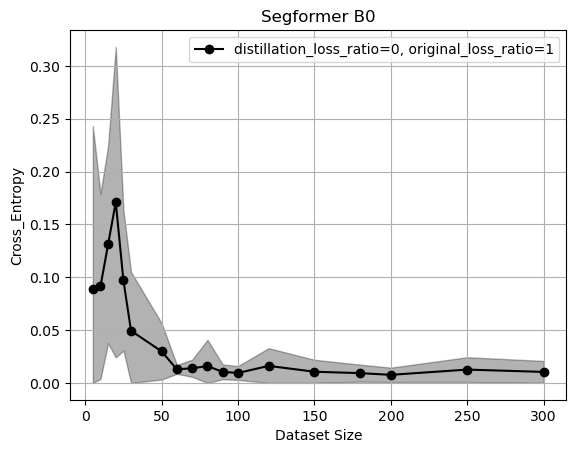

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()